In [11]:
import random
import numpy as np
from ParticleClass import hello as hell
from FuncionesGeneradorasListas import FuncionesListas as fl
import matplotlib.pyplot as plt
from FGeneradora import FuncionGeneradora as fg

In [12]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [42]:
%%time
%%cython 
#Se importan las cosas necesarias 
from ParticleClass import hello as hell
import timeit
from FuncionesGeneradorasListas import FuncionesListas as fl
import matplotlib.pyplot as plt
from FGeneradora import FuncionGeneradora as fg

#Parametros simulación
cdef float v1 = 50  #Velocidad mínima
cdef float v2 = 75  #Velocidad máxima
cdef float dt = 0.01 #tamaño del paso
cdef float Lx = 100 #Tamñaño de la caja 
cdef float Ly = 100 
cdef int n = 11 #número de partículas
cdef float m = 1 #masa 
cdef float r = 2 #radio
cdef int nt  = 10000 #número de pasos
cdef int j,k,i


par = fg.funcion_generadora(Lx,Ly,v1,v2,m,r,n) #se crea la configuración inicial de las partículas
lista_posiciones = fl.listas_para_llenar_posiciones(n) ## lista que contiene las posiciones de cada partícula 
                                                       ## en cada paso
lista_velocidades = fl.listas_para_llenar_componentes_velocidad(n)

for j in range(nt):

    for k in range(n):
        lista_posiciones[k][0].append(par[k].posicion[0])  #Se añade la posición en x de cada partícula
        lista_posiciones[k][1].append(par[k].posicion[1])  #Se añade la posicion en y de cada partícula
        lista_velocidades[k][0].append(par[k].velocidad[0]) #Se añade la velocidad en x de cada partícula
        lista_velocidades[k][1].append(par[k].velocidad[1]) #Se añade la velocidad en y de cada partícula
    for p in par:     
        for i in range(par.index(p)+1,n): #Revisamos las colisiones entre partículas
            if  p.posicion[0] == par[i].posicion[0] and p.posicion[1] == par[i].posicion[1]:
                continue 
            
            elif p.ver_colision_pp(par[i])  :
                #print("CHOQUE")
                p.resolver_colision_particula(par[i])
    for p in par: 
        if p.ver_colision_muro(Lx,Ly): #Revisamos las condiciones de choque con la caja
            p.resolver_colision_muro(Lx,Ly)
        elif p.ver_colision_esquina(Lx,Ly): #Revisamos las condiciones de choque con las esquinas
            p.resolver_colision_esquina()
        p.paso_dt(dt)

CPU times: user 4.83 s, sys: 131 ms, total: 4.96 s
Wall time: 6.11 s


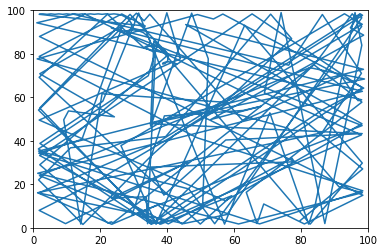

In [43]:
###########################PLOT DE LA TRAYECTORIA DE UNA PARTÍCULA--PARA PRUEBAS###############################
plt.plot(lista_posiciones[0][0],lista_posiciones[0][1])
#plt.plot(lista_posiciones[1][0],lista_posiciones[1][1])
#plt.plot(lista_posiciones[2][0],lista_posiciones[2][1])

plt.xlim((0,100))
plt.ylim((0,100))
plt.show()


In [31]:
print(par[0].posicion)

[58.34613963 62.70027744]


In [83]:
#Los datos de las velocidades en .csv
import csv 
with open('datos_velocidades_en_x','w',newline = '') as file:
    writer = csv.writer(file)
    for j in range(n):
        writer.writerow(lista_velocidades[j][0])


In [84]:
#Los datos de las velocidades en .csv
import csv 
with open('datos_velocidades_en_y','w',newline = '') as file:
    writer = csv.writer(file)
    for j in range(n):
        writer.writerow(lista_velocidades[j][1])

In [63]:
for p in par:
    print(p.velocidad)

[  50.58733792 -105.56728296]
[32.17956322 31.46319188]
[-44.28395965  65.22204276]
[-17.03339974 -14.50747146]
[ 58.10143277 -17.45299201]
[-25.81551925 -78.6282893 ]
[  67.79534674 -119.94516698]
[34.86003992 75.13494827]
[-63.15089311 -58.34185203]
[ -53.46225645 -107.78689914]


In [76]:
lista_velocidades[0]

[[52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  52.8878173828125,
  -8.818903000844593,
  -8.8189030008445

In [48]:
par[0].velocidad

array([ 85.88483414, -70.7961825 ])